<a href="https://colab.research.google.com/github/minerva-mcgonagraph/travelingsalesman/blob/main/travelingsalesman1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Artifically Intelligent Traveling Salesman Part 1: A Simple Algorithm

A traveling salesman has a number of cities to visit. What is the fastest way he can traverse through every city and return home? This is known as the Traveling Salesman problem, and it has many applications.

Mathematically, we can represent this problem using a complete weighted directed graph on $n$ vertices. Each vertex represents a city and the weight (or cost) of each edge represents the time it takes to travel from one city to another. Traversing every vertex exactly once and returning to the start is a Hamiltonian cycle, and there are $(n-1)!$ such cycles. (If the graph is undirected, that is, if the distance from $A$ to $B$ is the same as $B$ to $A$, there are half as many possible cycles.)

As factorials get very large very quickly, checking each possible path is quite a task. We will create a simple artificial intelligence algorithm to try and find a cheap path. For this demonstration we use data with no underlying structure.

##Instructions for this notebook

Press play in each code block after setting the user input if needed.

#Create Data

We will represent the complete weighted directed graph on $n$ vertices as an $n\times n$ DataFrame where entry $(i,j)$ represents the cost $c$ of edge $e_{ij}$. The costs are normalized to be between $0$ and $1$.

Set $n$ and and the data distribution and press play to create the graph.

          0         1         2  ...         7         8         9
0  0.681981  0.283642  0.776112  ...  0.977949  1.000000  0.231457
1  0.520876  0.295805  0.873088  ...  0.580235  0.424506  0.069569
2  0.396643  0.498300  0.580380  ...  0.931568  0.837443  0.826176
3  0.971681  0.034434  0.710599  ...  0.448220  0.749272  0.581624
4  0.635618  0.717124  0.768554  ...  0.857501  0.000000  0.859387
5  0.850313  0.484482  0.095921  ...  0.380962  0.599332  0.674039
6  0.231801  0.253873  0.667740  ...  0.627398  0.335963  0.550534
7  0.096315  0.615471  0.759378  ...  0.844011  0.966992  0.403245
8  0.679985  0.253363  0.329297  ...  0.874635  0.697729  0.479960
9  0.385426  0.114561  0.092765  ...  0.947041  0.102565  0.910717

[10 rows x 10 columns]


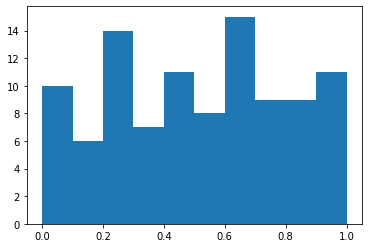

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math #for factorial calculation
%matplotlib inline
from ipywidgets import widgets, interactive

#@title Set the number of vertices and data distribution type
n =  10#@param {type:"integer"}
data_distribution = 'uniform' #@param['uniform', 'normal']

def create_graph(distribution):
  if distribution == 'uniform':
    graph = np.random.random((n,n))
    #func = np.vectorize(lambda x: 1-x)
    #weighted_Kn_array = func(graph)
  elif distribution == 'normal':
    graph = np.random.normal(0, 1, (n,n))

  #normalize data
  costs = list(itertools.chain(*graph))
  normalize = np.vectorize(lambda x: (x - min(costs))/(max(costs) - min(costs)))
  
  graph_normalized = normalize(graph)
  costs_normalized = list(itertools.chain(*graph_normalized))

  return graph_normalized, costs_normalized

graph_Kn, edges = create_graph(data_distribution)

#visualize the data
plt.hist(edges, bins=n)

weighted_Kn = pd.DataFrame(data=graph_Kn, index=None, columns=None)
print(weighted_Kn)

Now we will need our training set. Without loss of generality, we will set vertex 0 to be the start and end. The training set consists of a number of cycles, each represented as a list; the cost of the cycle; and the distance of each vertex from the start.

Set the size of the training set and press play.

In [ ]:
#@title Set size of training set
size = 500 #@param {type:"slider", min:100, max:10000, step:10}
training_set_size=min(size, math.factorial(n-1))

cycle_list = []

for i in range(training_set_size):
  cycle_list.append(np.random.permutation(range(1,n,1)).tolist())

for i in cycle_list:
  i.append(0)
  i.insert(0,0)

def cycle_cost(cycle):
  """
  Calculates the cost of each cycle in a list.

  Args:
    cycle: a list of permuted integers 1 to n-1, with 0 inserted at the start and end
  Returns:
    The cost of the cycle.
  """
  #each cycle: [0, 1, ..., n-2, n-1, 0], length n+1
  #cost 01, 12, 23, ..., n-2 n-1, n-1 0
  #cost indices: k k+1, where
  #k ranges from 0 to n-1, which is range(n)
  #n = len(cycle)-1
  cost = 0
  for k in range(len(cycle)-1):
    cost += weighted_Kn.at[cycle[k], cycle[k+1]]
  return cost

training_set = []
for i in range(len(cycle_list)):
  training_set.append([cycle_list[i], cycle_cost(cycle_list[i])])

df_train = pd.DataFrame(training_set, columns = ['cycle', 'cost'])

#print(df_train.head())

#extract vertex positions relative to the starting vertex

#col i is the distance of vertex i from vertex 0
#which is simply the index of i in the cycle
for i in range(1, n, 1):
  col = str(i)
  df_train[col] = df_train['cycle'].apply(lambda x: x.index(i))

#randomize data
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(df_train.head())
print(df_train.tail())



                               cycle      cost  1  2  3  4  5  6  7  8  9
0  [0, 2, 3, 6, 4, 5, 9, 1, 8, 7, 0]  4.825169  7  1  2  4  5  3  9  8  6
1  [0, 7, 3, 1, 4, 5, 2, 9, 8, 6, 0]  4.123600  3  6  2  4  5  9  1  8  7
2  [0, 7, 4, 9, 3, 5, 8, 6, 2, 1, 0]  5.832529  9  8  4  2  5  7  1  6  3
3  [0, 5, 1, 9, 3, 2, 7, 6, 8, 4, 0]  4.640383  2  5  4  9  1  7  6  8  3
4  [0, 8, 7, 5, 3, 4, 2, 6, 9, 1, 0]  5.689130  9  6  4  5  3  7  2  1  8
                                 cycle      cost  1  2  3  4  5  6  7  8  9
495  [0, 5, 6, 2, 8, 3, 1, 4, 9, 7, 0]  5.130369  6  3  5  7  1  2  9  4  8
496  [0, 2, 4, 6, 3, 5, 8, 7, 9, 1, 0]  5.286683  9  1  4  2  5  3  7  6  8
497  [0, 5, 1, 6, 4, 2, 9, 3, 8, 7, 0]  5.520875  2  5  7  4  1  3  9  8  6
498  [0, 6, 7, 1, 5, 3, 2, 8, 9, 4, 0]  4.907937  3  6  5  9  4  1  2  7  8
499  [0, 2, 8, 7, 1, 4, 6, 3, 5, 9, 0]  6.102950  4  1  7  5  8  6  3  2  9


Now let's visualize the data to see if there's any correlation between vertex position and cost of cycle. If there is, then the graph for a vertex should show lines getting shorter as they approach the desired position. Since the data is random with no underlying structure there probably won't be much correlation. A large training set may also obscure any visible patterns.

In [ ]:
#@title Visualize the data
#create dropdown menu to select vertex
verts = list(map(str, range(1,n,1)))
vert = widgets.Dropdown(
    options=verts,
    value='1',
    description='Vertex',
)

#function for plot
def plotByIndex(vert):
  """
  Plots the index of a vertex compared to the cost of that path.

  Args:
    vert (str): the vertex
  Returns:
    A seaborn graph
  """
  plot = sns.scatterplot(x=vert, y='cost', data=df_train)
  plot.set(xlabel="Position Relative to Vertex 0", ylabel="Cost of Cycle", xticks=range(1,n,1))
  return plot

interactive(plotByIndex, vert=vert)

interactive(children=(Dropdown(description='Vertex', options=('1', '2', '3', '4', '5', '6', '7', '8', '9'), va…

##Train the Model

Now let's train the model. We use rank to refer to the position of a vertex relative to vertex $0$ and weight as a temporary placeholder for the rank.

The data is randomized before starting training.

For each example, the rank of each vertex will be adjusted by a learning rate to more closely match a cheap example or less closely match an expensive example. More precisely, we will adjust the weight of the vertex by $$\left(\text{learning rate}\right)\cdot\left(r-w\right)$$ where $w$ is the current weight of the vertex and $r$ is the rank of that vertex in the example. If the cost of the example is cheap, add this factor to the current weight of the vertex. If the cost of the example is not cheap, subtract. Then map the weights to new ranks and repeat for each example.

The hyperparameters here are $\text{learning_rate}\in(0,1)$ and $\text{cheap}\in(0,1)$, the average cost of an edge in the example.

<Figure size 432x288 with 0 Axes>

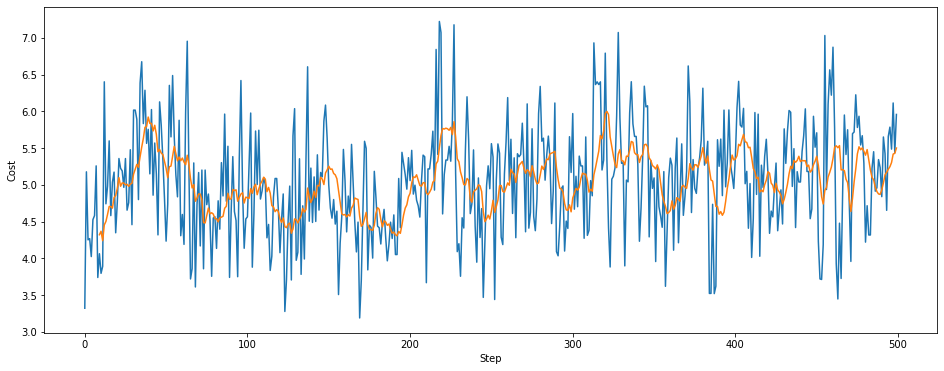

In [ ]:
#@title Set hyperparameters and train model
learning_rate = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
cheap = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}

#randomize data
df_train = df_train.sample(frac=1).reset_index(drop=True)
#print(df_train.head())

def map_weights_to_rank(model):

  #start with [[i, w_i]]

  def sort_by_weights(ele):
      #ele = [i, w_i]
      return ele[1]
  
  model.sort(key=sort_by_weights)
  #now have [[i, w_i]] where w_i <= w_{i+1}

  #map w_i to r_i = the index of the element [i, w_i] + 1
  for ele in model:
    ele[1] = model.index(ele) + 1
  
  #now have [[i, r_i]] where r_i = 1,...,n
  
  #sort by vertex
  def sort_by_vert(ele):
    #ele = [i, r_i]  
    return ele[0]
    
  model.sort(key=sort_by_vert)
  #now have [[1,r_1],...,[n,r_n]]
  
  
  return model

def model_to_cycle(model):
  """
  Turns the model into a cycle in order to calculate the cycle cost.
  Args:
    model: a list in the format [[1, r_1], ..., [n, r_n]]
  Returns:
    model_cycle: a list in the format [0, v_{r_1}, ..., v_{r_n}, 0]
  """
  #sort model ele by r_i
  #from this order, create list v_{r_1},...,v_{r_n}
  #append 0
  #insert(0,0)

  def sort_by_rank(ele):
    #ele = [i, r_i]
    return ele[1]
  
  model.sort(key=sort_by_rank)

  #now have model = [[v_{r_1}, 1], ..., [v_{r_n}, n]]
  
  model_cycle = [0]

  for ele in model:
    model_cycle.append(ele[0])
  
  model_cycle.append(0)

  return model_cycle

#Read one example at a time
#For each example, adjust weight of each vertex by the learning rate
#assuming uniformly distributed edge costs \in (0,1], the average path cost is 0.5*n. 
#Use other coefficients as hyperparameter.
#ie, the coefficient serves as a quartile measure
#cheap=p translates to the average cost of an edge is at most p

def train_model(data=df_train, default_weight=0, learning_rate=0.5, cheap=0.5):
    
  #initialize model to be [[1,0], [2,0],...,[n,0]]
  model=[]
  for i in range(1,n,1):
    model.append([i,default_weight])

  #initialize progress tracker
  progress=[]
  
  #train the model, one example at a time
  for example in range(len(data)):
    cost = data.at[example, 'cost']
    
    #adjust the weight of each vertex
    for i in range(1,n,1): #for each vertex
      w_i = model[i-1][1] #set w_i to be [i, w_i] in the model
      r_i = data.at[example, str(i)] #set r_i to be rank of vertex i in the example
      if cost <= (cheap*n): #if the cost of the cycle is cheap, adjust rank to be closer to rank in example
        w_i += (learning_rate)*(r_i-w_i)
      else: #if cost is not cheap, adjust rank to be farther away
        w_i -= (learning_rate)*(r_i-w_i)
      
      #assign the new weight to the model
      model[i-1][1] = w_i

    #have model = [[1, w_1], ..., [n-1, w_{n-1}]]

    model = map_weights_to_rank(model)
    
    #now have model = [[1, r_1], ..., [n-1, r_{n-1}]]
    
    #calculate cost of model
    step = example
    
    model_cycle = model_to_cycle(model)

    #use same algorithm as before to calculate cost of the model
    cost_of_model = 0
    for i in range(len(model_cycle) - 1):
      cost_of_model += weighted_Kn.at[model_cycle[i],model_cycle[i+1]]
    
    #append the progress tracker
    progress.append([step, model_cycle, cost_of_model])
  
  return progress

#visualize model training
training = train_model(learning_rate=learning_rate, cheap=cheap)
df_training = pd.DataFrame(training, columns=['step', 'cycle', 'cost'])
df_training['rolling_cost'] = df_training['cost'].rolling(n).mean()
plt.figure()
df_training[['cost', 'rolling_cost']].plot(legend=False, 
                                           figsize=(16,6),
                                           xlabel='Step',
                                           ylabel='Cost')

#Conclusion

If this algorithm could 'learn' the underlying structure of a graph to find a cheap path, we would expect to see a few things. First, that randomizing the data should not affect training. Second, that given adjusted hyperparameters, the cost should show a trend.

[Next we will apply this algorithm to cities on a plane.](https://colab.research.google.com/github/minerva-mcgonagraph/travelingsalesman/blob/main/travelingsalesman2.ipynb)